## 安装torch

创建虚拟环境 (推荐使用uv工具)

- pip install uv

- mkdir [项目文件夹名称]

- cd [项目文件夹名称]

- uv venv [环境名称] -p python[版本]

- source [环境名称]/bin/activate

使用pip安装torch

- uv pip install torch torchvision

## 初始化

In [1]:
import numpy as np

import torch   # torch 主要函数库
from torch import nn   # 神经网络相关
from torch.utils.data import DataLoader, Dataset, random_split  # 数据加载器
import torch.optim as optim  # 参数调节器相关

import matplotlib.pyplot as plt

## 一个简单的例子 —— 函数拟合

### 数据准备

In [2]:
# 定义我们想要拟合的目标函数
def target_function(x):
    return np.sin(x / 2) + np.exp(-0.1 * x**2) * np.cos(5 * x)

# 我们可以为函数添加一些噪声，让任务更真实
def noisy_target_function(x):
    return target_function(x) + 0.1 * np.random.randn()

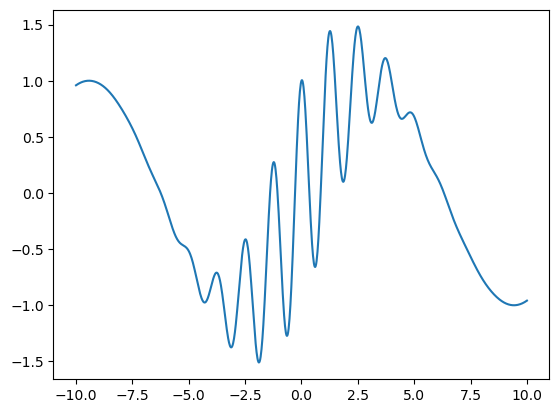

In [3]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, target_function(x))

In [ ]:
len()

In [4]:
class FunctionDataset(Dataset):
    """一个动态生成数据的Dataset"""
    def __init__(self, func, x_range=(-10, 10), n_samples=10000):
        self.func = func
        self.x_range = x_range
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        x_val = (self.x_range[1] - self.x_range[0]) * np.random.rand() + self.x_range[0]
        y_val = self.func(x_val)
        
        x = torch.tensor([x_val], dtype=torch.float32)
        y = torch.tensor([y_val], dtype=torch.float32)
        
        return x, y

### 网络定义

In [5]:
class Network(nn.Module):
    """
    一个全连接神经网络
    """
    def __init__(self, hidden_dim=128):
        super(Network, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.network(x)

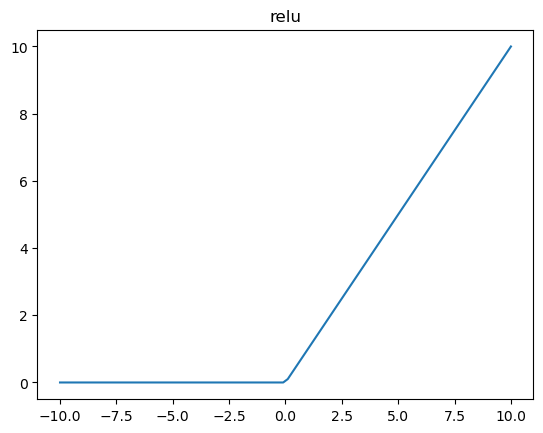

In [4]:
x = torch.linspace(-10., 10., steps=100)
plt.plot(x, nn.ReLU()(x))
plt.title('relu')
plt.show()

### 训练

In [6]:
# --- 设置超参数和设备 ---
LEARNING_RATE = 1e-3
BATCH_SIZE = 512
EPOCHS = 200  # *** 增加训练周期以更好地拟合复杂函数 ***
X_RANGE = (-10, 10)
NUM_SAMPLES_PER_EPOCH = 20000

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 准备数据 ---
train_dataset = FunctionDataset(noisy_target_function, x_range=X_RANGE, n_samples=NUM_SAMPLES_PER_EPOCH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- 初始化模型、损失函数和优化器 ---
model = Network(hidden_dim=128).to(device) # *** 使用更强大的模型 ***
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 训练模型 ---
print("Starting training with a more complex function...")
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    # 每10个epoch打印一次损失，避免信息刷屏
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {avg_loss:.6f}")

print("Training finished!")

Using device: cuda:1
Starting training with a more complex function...
Epoch 10/200, Average Loss: 0.058662
Epoch 20/200, Average Loss: 0.034428
Epoch 30/200, Average Loss: 0.022347
Epoch 40/200, Average Loss: 0.018028
Epoch 50/200, Average Loss: 0.014576
Epoch 60/200, Average Loss: 0.013586
Epoch 70/200, Average Loss: 0.012801
Epoch 80/200, Average Loss: 0.013448
Epoch 90/200, Average Loss: 0.011601
Epoch 100/200, Average Loss: 0.012230
Epoch 110/200, Average Loss: 0.011736
Epoch 120/200, Average Loss: 0.011748
Epoch 130/200, Average Loss: 0.012542
Epoch 140/200, Average Loss: 0.011409
Epoch 150/200, Average Loss: 0.012132
Epoch 160/200, Average Loss: 0.011858
Epoch 170/200, Average Loss: 0.011167
Epoch 180/200, Average Loss: 0.011083
Epoch 190/200, Average Loss: 0.011320
Epoch 200/200, Average Loss: 0.012253
Training finished!


### 检验

Visualizing results...


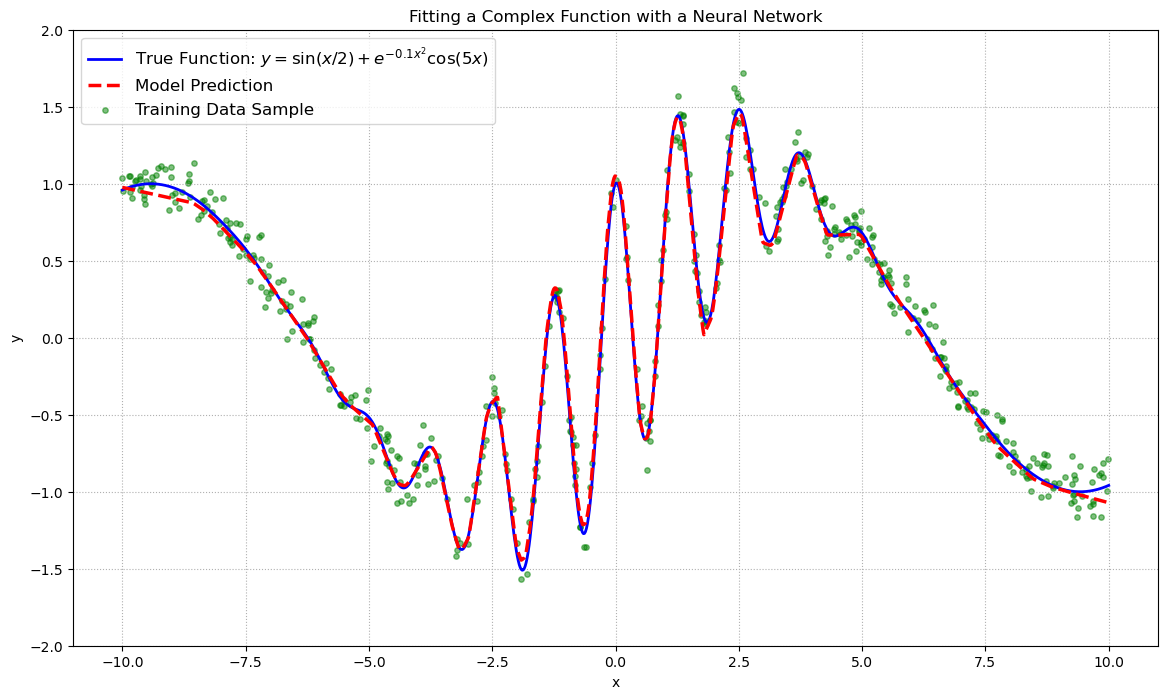

In [7]:
print("Visualizing results...")

# 1. 生成用于绘图的x值
x_test = torch.linspace(X_RANGE[0], X_RANGE[1], 1000).view(-1, 1).to(device) # 增加点数以显示更多细节

# 2. 计算真实函数值
y_true = target_function(x_test.cpu().numpy())

# 3. 使用训练好的模型进行预测
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

y_pred_np = y_pred.cpu().numpy()

# 4. 绘制图像
plt.figure(figsize=(14, 8))
plt.plot(x_test.cpu().numpy(), y_true, label='True Function: $y = \sin(x/2) + e^{-0.1x^2}\cos(5x)$', color='blue', linewidth=2)
plt.plot(x_test.cpu().numpy(), y_pred_np, label='Model Prediction', color='red', linestyle='--', linewidth=2.5)

# 绘制一些训练数据点作为参考
sample_x, sample_y = next(iter(train_loader))
plt.scatter(sample_x.numpy(), sample_y.numpy(), label='Training Data Sample', color='green', alpha=0.5, s=15)

plt.title('Fitting a Complex Function with a Neural Network')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=12)
plt.grid(True, linestyle=':')
plt.ylim(-2, 2) # 设置y轴范围，让图像更清晰
plt.show()

## Tensor

tensor 是 torch 库的主要数据类型，其地位等于 numpy 库中的 array

### 定义 tensor

从列表定义 tensor

In [8]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print(x_data)

tensor([[1, 2],
        [3, 4]])


从 numpy array 定义 tensor

In [9]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

tensor([[1, 2],
        [3, 4]])


In [10]:
x_np.numpy()

array([[1, 2],
       [3, 4]])

常用定义方法

In [11]:
shape = (2,3,)
rand_tensor = torch.rand(shape)  # 随机张量，[0, 1]之间
ones_tensor = torch.ones(shape)  # 全为1
zeros_tensor = torch.zeros(shape)   # 全为0

print(f"随机张量: \n {rand_tensor} \n")
print(f"单位张量: \n {ones_tensor} \n")
print(f"零张量: \n {zeros_tensor}")

随机张量: 
 tensor([[0.7296, 0.0204, 0.0455],
        [0.3082, 0.2020, 0.5644]]) 

单位张量: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

零张量: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### Tensor 的属性

形状

In [13]:
x_data

tensor([[1, 2],
        [3, 4]])

In [12]:
x_data.shape

torch.Size([2, 2])

元素数据类型

In [5]:
x_data.dtype

torch.int64

设备

In [15]:
x_data.to(device).device

device(type='cuda', index=1)

### 常用操作

筛选

In [16]:
print(f"原始张量: \n{rand_tensor}\n")
print(f"第一行: \n{rand_tensor[0]}\n")
print(f"第二列: \n{rand_tensor[:, 1]}\n")
print(f"对角项: \n{rand_tensor.diag()}\n")

原始张量: 
tensor([[0.7296, 0.0204, 0.0455],
        [0.3082, 0.2020, 0.5644]])

第一行: 
tensor([0.7296, 0.0204, 0.0455])

第二列: 
tensor([0.0204, 0.2020])

对角项: 
tensor([0.7296, 0.2020])



形状操作

In [21]:
print(f"转置: \n{rand_tensor.transpose(1, 0)}\n")

转置: 
tensor([[0.6596, 0.4263],
        [0.6333, 0.2771],
        [0.3032, 0.5949]])



In [19]:
rand_tensor

tensor([[0.7296, 0.0204, 0.0455],
        [0.3082, 0.2020, 0.5644]])

In [20]:
ones_tensor

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [17]:
print(f"拼接: \n{torch.cat((rand_tensor, ones_tensor))}")
print(f"拼接: \n{torch.cat((rand_tensor, ones_tensor), dim=1)}")

拼接: 
tensor([[0.7296, 0.0204, 0.0455],
        [0.3082, 0.2020, 0.5644],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]])
拼接: 
tensor([[0.7296, 0.0204, 0.0455, 1.0000, 1.0000, 1.0000],
        [0.3082, 0.2020, 0.5644, 1.0000, 1.0000, 1.0000]])


In [23]:
torch.tensor([rand_tensor, ones_tensor])

ValueError: only one element tensors can be converted to Python scalars

In [21]:
print(f"堆叠: \n{torch.stack((rand_tensor, ones_tensor))}")
print(f"堆叠: \n{torch.stack((rand_tensor, ones_tensor), dim=1)}")

堆叠: 
tensor([[[0.7296, 0.0204, 0.0455],
         [0.3082, 0.2020, 0.5644]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]]])
堆叠: 
tensor([[[0.7296, 0.0204, 0.0455],
         [1.0000, 1.0000, 1.0000]],

        [[0.3082, 0.2020, 0.5644],
         [1.0000, 1.0000, 1.0000]]])


In [25]:
print(f"扩增维度: \n{rand_tensor.unsqueeze(-1)}\n{rand_tensor.unsqueeze(-1).shape}\n")
print(f"扩增维度: \n{rand_tensor.unsqueeze(0)}\n{rand_tensor.unsqueeze(0).shape}\n")
print(f"扩增维度: \n{rand_tensor.unsqueeze(1)}\n{rand_tensor.unsqueeze(1).shape}\n")

扩增维度: 
tensor([[[0.6596],
         [0.6333],
         [0.3032]],

        [[0.4263],
         [0.2771],
         [0.5949]]])
torch.Size([2, 3, 1])

扩增维度: 
tensor([[[0.6596, 0.6333, 0.3032],
         [0.4263, 0.2771, 0.5949]]])
torch.Size([1, 2, 3])

扩增维度: 
tensor([[[0.6596, 0.6333, 0.3032]],

        [[0.4263, 0.2771, 0.5949]]])
torch.Size([2, 1, 3])



In [25]:
print(f"展平: \n{rand_tensor.flatten()}\n{rand_tensor.flatten().shape}\n")

展平: 
tensor([0.7296, 0.0204, 0.0455, 0.3082, 0.2020, 0.5644])
torch.Size([6])



变更数据类型与设备

In [26]:
torch.complex32

torch.complex32

In [17]:
print(f"浮点数,\n {ones_tensor.to(torch.float32)}\n")  # 或 ones_tensor.float()
print(f"布尔类,\n {ones_tensor.to(torch.bool)}\n")   # 或 ones_tensor.bool()
ones_tensor_gpu = ones_tensor.to("cuda:0")
print(f"使用GPU,\n {ones_tensor_gpu.device}\n")
ones_tensor_cpu = ones_tensor.to("cpu")
print(f"使用CPU,\n {ones_tensor_cpu.device}\n")  # 或 ones_tensor.cpu()

浮点数,
 tensor([[1., 1., 1.],
        [1., 1., 1.]])

布尔类,
 tensor([[True, True, True],
        [True, True, True]])

使用GPU,
 cuda:0

使用CPU,
 cpu



## 自动微分

指定可微变量

In [27]:
x = torch.linspace(0., 2., steps=25, requires_grad=True)
print(x)

tensor([0.0000, 0.0833, 0.1667, 0.2500, 0.3333, 0.4167, 0.5000, 0.5833, 0.6667,
        0.7500, 0.8333, 0.9167, 1.0000, 1.0833, 1.1667, 1.2500, 1.3333, 1.4167,
        1.5000, 1.5833, 1.6667, 1.7500, 1.8333, 1.9167, 2.0000],
       requires_grad=True)


计算标量函数

In [28]:
w = torch.rand_like(x)
y = torch.sum(x * w)
y.backward()

验证梯度

In [29]:
print(torch.equal(w, x.grad))

True


## 神经网络

### 层定义

线性层

In [ ]:
input_dim = 32
output_dim = 256
nn.Linear(input_dim, output_dim)

非线性层

Text(0.5, 1.0, 'relu')

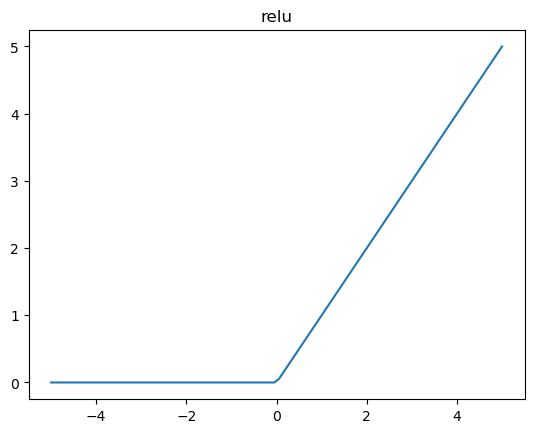

In [ ]:
x = torch.linspace(-10., 10., steps=100)
plt.plot(x, nn.ReLU()(x))
plt.title('relu')
plt.show()

Text(0.5, 1.0, 'leaky relu')

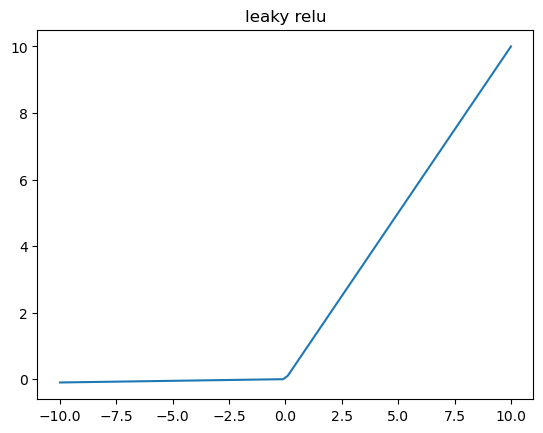

In [ ]:
x = torch.linspace(-10., 10., steps=100)
plt.plot(x, nn.LeakyReLU()(x))
plt.title('leaky relu')
plt.show()

Text(0.5, 1.0, 'gelu')

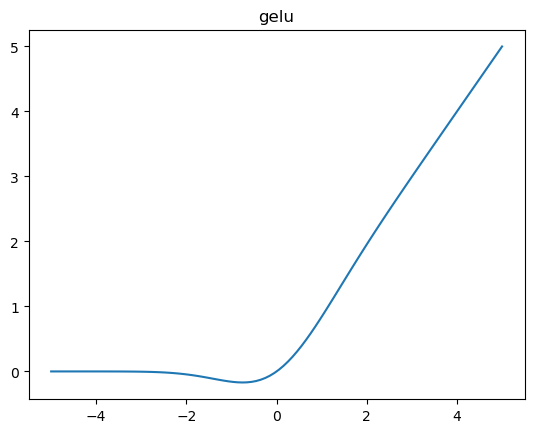

In [ ]:
x = torch.linspace(-10., 10., steps=100)
plt.plot(x, nn.GELU()(x))
plt.title('gelu')
plt.show()

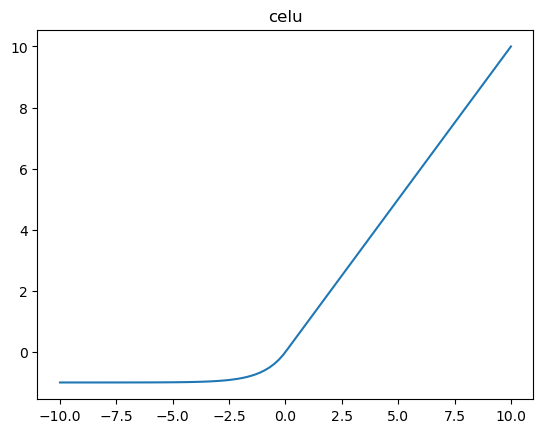

In [102]:
x = torch.linspace(-10., 10., steps=100)
plt.plot(x, nn.CELU()(x))
plt.title('celu')
plt.show()

Text(0.5, 1.0, 'sigmoid')

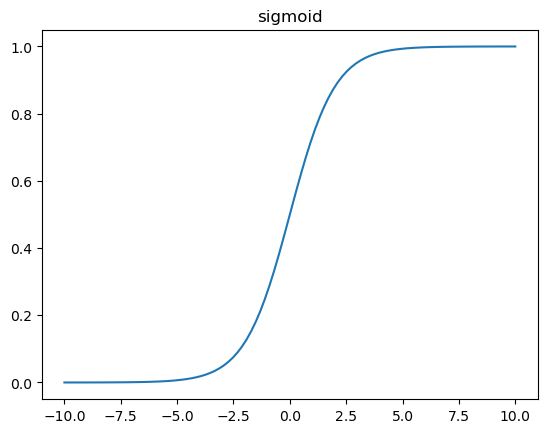

In [ ]:
x = torch.linspace(-10., 10., steps=100)
plt.plot(x, nn.Sigmoid()(x))
plt.title('sigmoid')
plt.show()

特殊层

In [ ]:
nn.MaxPool2d   # 池化
nn.Dropout     # 随机去除参数
nn.Parameter   # 单一参数

In [ ]:
alpha = nn.Parameter()
torch.exp(-alpha)

组合

In [ ]:
nn.Sequential(nn.Linear(28*28, 512),
              nn.ReLU(),
              nn.Linear(512, 512),
              nn.ReLU(),
              nn.Linear(512, 10),)

In [ ]:
nn.ModuleList([nn.Linear(10, 10) for _ in range(10)])

### 预定义网络

卷积网络

In [ ]:
nn.Conv2d
nn.Conv3d

循环网络

In [ ]:
nn.RNN
nn.GRU
nn.LSTM

注意力与Transformer

In [ ]:
nn.attention
nn.Transformer
nn.TransformerDecoder
nn.TransformerEncoder

### 完整网络

In [ ]:
class Network(nn.Module):
    """
    一个全连接神经网络
    """
    def __init__(self):
        super(Network, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.network(x)

提取网络中的参数

In [ ]:
model.parameters()

## 数据

通常使用Dataset的子类，其定义必须包含：
1. 初始化方法 __init__
2. 长度 __len__
3. 抽取一个元素 __getitem__

In [ ]:
class FunctionDataset(Dataset):
    """一个动态生成数据的Dataset"""
    def __init__(self, func, x_range=(-10, 10), n_samples=10000):
        self.func = func
        self.x_range = x_range
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        x_val = (self.x_range[1] - self.x_range[0]) * np.random.rand() + self.x_range[0]
        y_val = self.func(x_val)
        
        x = torch.tensor([x_val], dtype=torch.float32)
        y = torch.tensor([y_val], dtype=torch.float32)
        
        return x, y

将dataset用DataLoader包装，方便抽取

In [ ]:
BATCH_SIZE = 512
X_RANGE = (-10, 10)
NUM_SAMPLES_PER_EPOCH = 20000

train_dataset = FunctionDataset(noisy_target_function, x_range=X_RANGE, n_samples=NUM_SAMPLES_PER_EPOCH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

自动分割数据集

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(train_dataset)

## 训练

超参数

In [ ]:
LEARNING_RATE = 1e-3  # 学习率
EPOCHS = 200   # 循环次数

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  # 设备
print(f"Using device: {device}")

初始化模型，损失函数，调参器

In [ ]:
model = Network().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)   # 参数调节器

常用损失函数

In [ ]:
nn.MSELoss  # 均方差
nn.L1Loss   # 均绝对差
nn.CrossEntropyLoss   # 交叉熵
nn.KLDivLoss   # K-L散度
nn.NLLLoss     # 负对数似然

常用调参器

In [ ]:
optim.SGD    # 标准的随机梯度下降方法
optim.Adam   # 最常用的带动量项的方法
optim.LBFGS  # 效率最高的二阶下降方法

训练过程

In [ ]:
# --- 训练模型 ---
print("Starting training with a more complex function...")
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    # 每10个epoch打印一次损失，避免信息刷屏
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {avg_loss:.6f}")

print("Training finished!")